<a href="https://colab.research.google.com/github/Gibsdevops/NLP_with_tensorflow/blob/main/nlp_with_multiple_types_of_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import numpy as np
import matplotlib.pyplot as plt


In [4]:
#get the dataset

dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.N20P1F_2.0.0/glue-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.N20P1F_2.0.0/glue-validation.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/glue/sst2/incomplete.N20P1F_2.0.0/glue-test.tfrecord*...:   0%|          |…

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/2.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence': Text(shape=(), dtype=string),
})


In [5]:
print(info.features['label'].num_classes)
print(info.features['label'].names)

2
['negative', 'positive']


In [6]:
#get the training and the validation datasets

dataset_train = dataset['train']
dataset_validation = dataset['validation']

In [7]:
dataset_train

<_PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [19]:
#print some of the entries from here

for example in dataset_train.take(2):
  review, label = example["sentence"], example["label"]
  print("review", review)
  print("label", label.numpy())

review tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
label 0
review tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
label 0


In [22]:
#num of insatnces in the dataset_train

num_train_examples = len(dataset_train)
print("training examples are:", num_train_examples)


#validation examples
num_validation_examples = len(dataset_validation)
print("\n \n validation examples are:", num_validation_examples)


training examples are: 67349

 
 validation examples are: 872


In [21]:
#use 1000 entries fro training  and 800 validation

training_reviews = []
training_labels = []

validation_reviews = []
validation_labels = []

for item in dataset_train.take(1000):
  review, label = item['sentence'], item['label']
  training_reviews.append(str(review.numpy()))
  training_labels.append(str(label.numpy()))

#check how many instances u v got
print ("\nNumber of training reviews is: ", len(training_reviews))

# Get the validation data
# there's only about 800 items, so take them all
for item in dataset_validation.take(-1):
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))


Number of training reviews is:  1000

Number of validation reviews is:  872


In [23]:
# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])


b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0


In [24]:
# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])

b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


Tokenize the words and sequence the sentences

In [26]:
# There's a total of 21224 words in the reviews
# but many of them are irrelevant like with, it, of, on.
# If we take a subset of the training data, then the vocab
# will be smaller.

# A reasonable review might have about 50 words or so,
# so we can set max_length to 50 (but feel free to change it as you like)

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


In [30]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length,
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

# Convert training labels to integers before converting to numpy array
training_labels_final = np.array([int(label) for label in training_labels])
validation_labels_final = np.array(validation_labels)

create an embedding model

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train the model

num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels_final))


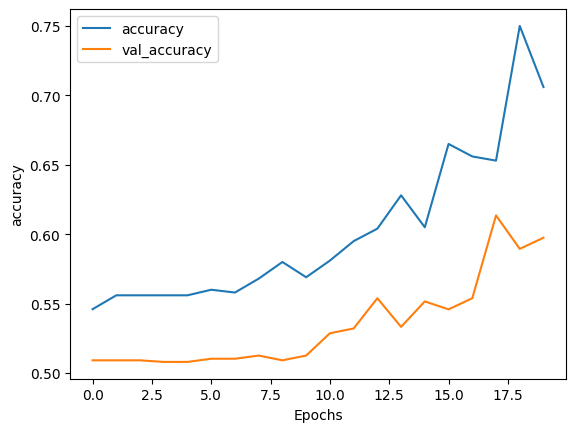

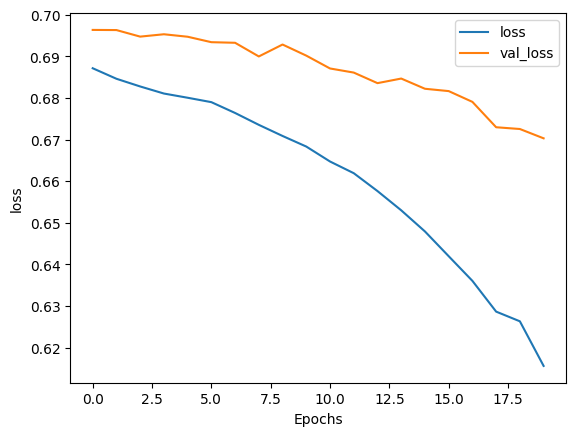

In [33]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [34]:
#Write a function to predict the sentiment of reviews

# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

new_reviews = [review1, review2, review3, review4]


In [35]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews

def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type,
                                 maxlen=max_length)
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
I loved this movie
[0.54712015]


that was the worst movie I've ever seen
[0.53102463]


too much violence even for a Bond film
[0.5281858]


a captivating recounting of a cherished myth
[0.59193444]




Define a function to train and show the results of models with different layers

In [36]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs,
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

using CNN

In [ ]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

using GRU

In [ ]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

Add a bidirectional LSTM

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.4963 - loss: 0.6935 - val_accuracy: 0.5034 - val_loss: 0.6930
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5134 - loss: 0.6928 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5450 - loss: 0.6920 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5476 - loss: 0.6916 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5457 - loss: 0.6908 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5814 - loss: 0.6891 - val_accuracy: 0.5092 - val_loss: 0.6931
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5659 - loss: 0.6885 - val_accuracy: 0.5092 - val_loss: 0.6932
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5600 - loss: 0.6883 - val_accuracy: 0.5092 - 

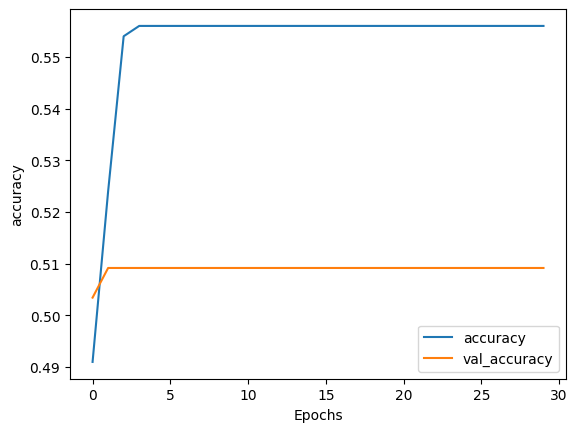

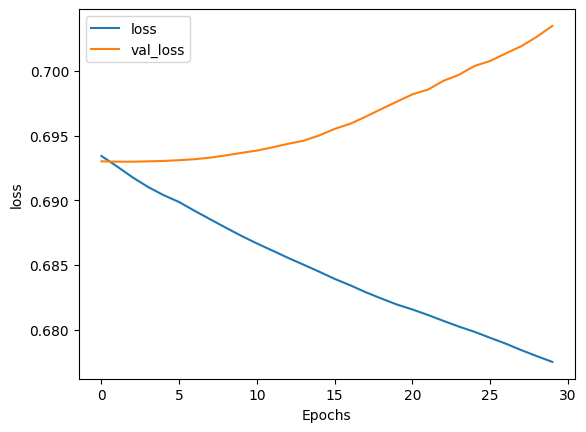

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
I loved this movie
[0.574828]


that was the worst movie I've ever seen
[0.55526793]


too much violence even for a Bond film
[0.5571349]


a captivating recounting of a cherished myth
[0.56641525]




In [39]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

using multiple bidirectional LSTMS

In [ ]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

In [41]:
# Write some new reviews

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time.
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director
 who made my most favorite movie ever, I was very disappointed in the tedious
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7,
               review8, review9, review10]


In [42]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
I loved this movie
[0.5471201]


that was the worst movie I've ever seen
[0.53102463]


too much violence even for a Bond film
[0.5281858]


a captivating recounting of a cherished myth
[0.59193444]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.39621645]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.51327354]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.45804217]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5198109]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedio

In [43]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
I loved this movie
[0.5234912]


that was the worst movie I've ever seen
[0.4838265]


too much violence even for a Bond film
[0.54244405]


a captivating recounting of a cherished myth
[0.5677532]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.51616627]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.5037283]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.4886898]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.53798753]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story

In [44]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
I loved this movie
[0.54537207]


that was the worst movie I've ever seen
[0.5454172]


too much violence even for a Bond film
[0.54097277]


a captivating recounting of a cherished myth
[0.5522707]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.54271674]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.5452546]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.54709995]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.54648554]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in th

In [45]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
I loved this movie
[0.57482797]


that was the worst movie I've ever seen
[0.55526793]


too much violence even for a Bond film
[0.5571349]


a captivating recounting of a cherished myth
[0.56641525]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.52400595]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.5442027]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.53622955]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5373519]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappo

In [46]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
I loved this movie
[0.00341568]


that was the worst movie I've ever seen
[0.00341751]


too much violence even for a Bond film
[0.00346561]


a captivating recounting of a cherished myth
[0.9981402]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.97357166]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99808615]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.00349959]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.99805707]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappoi